In [1]:
%load_ext autoreload
%autoreload 2

from gorillatracker.datasets.cxl import CXLDataset
from gorillatracker.model import EfficientNetV2Wrapper
from gorillatracker.transform_utils import SquarePad
import pandas as pd
import wandb
import torch
import torchvision.transforms as transforms

wandb.login()
wandb.init(mode="disabled")
api = wandb.Api()

artifact = api.artifact(
    "gorillas/Embedding-ALL-SPAC-Open/model-3ag1c2vf:v1",  # your artifact name
    type="model",
)
artifact_dir = artifact.download()
model = artifact_dir + "/model.ckpt"

# load model
checkpoint = torch.load(model, map_location=torch.device("cpu"))

model = EfficientNetV2Wrapper(  # switch this with the model you want to use
    model_name_or_path="EfficientNetV2_Large",
    from_scratch=False,
    loss_mode="softmax/arcface",
    weight_decay=0.001,
    lr_schedule="cosine",
    warmup_mode="cosine",
    warmup_epochs=10,
    max_epochs=100,
    initial_lr=0.01,
    start_lr=0.01,
    end_lr=0.0001,
    beta1=0.9,
    beta2=0.999,
    embedding_size=128,
)
# the following lines are necessary to load a model that was trained with arcface (the prototypes are saved in the state dict)
model.loss_module_train.prototypes = torch.nn.Parameter(checkpoint["state_dict"]["loss_module_train.prototypes"])
model.loss_module_val.prototypes = torch.nn.Parameter(checkpoint["state_dict"]["loss_module_val.prototypes"])

model.load_state_dict(checkpoint["state_dict"])
model.eval()

# generate table that contains labels and images and embeddings
df = pd.DataFrame(columns=["label", "image", "embedding"])
dataset = CXLDataset(
    data_dir="/workspaces/gorillatracker/data/splits/ground_truth-cxl-face_images-openset-reid-val-0-test-0-mintraincount-3-seed-42-train-50-val-25-test-25",
    partition="val",
    transform=transforms.Compose(  # use the transforms that were used for the model (except of course data augmentations)
        [
            SquarePad(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
)

for i in range(len(dataset)):
    image_tensor, label = dataset[i]
    label_string = dataset.mapping[label]
    image = transforms.ToPILImage()(image_tensor)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.228, 0.224, 0.225])(
        image_tensor
    )  # if your model was trained with normalization, you need to normalize the images here as well
    embedding = model(image_tensor.unsqueeze(0))
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "label_string": [label_string],
                    "label": [label],
                    "image": [image],
                    "embedding": [embedding[0].detach().numpy()],
                }
            ),
        ]
    )

    if i % 10 == 0:
        print(f"\rprocessed {i} images")
df = df.reset_index(drop=False)

/opt/conda/envs/research/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ER

In [ ]:
df

,index,label,image,embedding,label_string
0,0,2,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-0.8367091, 0.8015182, -0.6063515, 0.9147919,...",HU40
1,0,15,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-0.7270677, 0.06856993, 0.4832025, -0.2831621...",TU03
2,0,9,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-0.0808386, 0.568962, 0.5974397, -0.47306216,...",PL00
3,0,26,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-0.75864536, 0.57574815, -0.6341334, -0.04674...",YE40
4,0,21,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-1.2125582, 1.496591, -0.3937819, 0.5748896, ...",US01
...,...,...,...,...,...
121,0,14,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-0.5023384, 0.33735543, 0.7117031, 0.42811078...",PL46
122,0,21,<PIL.Image.Image image mode=RGB size=224x224 a...,"[0.3122592, 0.70295835, -1.534193, -0.17056334...",US01
123,0,5,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-0.74868226, 0.71905494, -0.27493265, 0.08398...",ME60
124,0,13,<PIL.Image.Image image mode=RGB size=224x224 a...,"[-0.4817579, 0.8698119, -0.020695603, -0.22562...",PL45


In [ ]:
from gorillatracker.metrics import knn
import numpy as np

df.label = df.label.astype(int)
df.embedding = df.embedding.apply(lambda x: np.array(x, dtype=np.float32))
d = knn(df.embedding, df.label.to_numpy(), k=1)
d

/workspaces/gorillatracker/src/gorillatracker/metrics.py:407: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/torch/csrc/utils/tensor_new.cpp:261.)
  val_embeddings = torch.tensor(val_embeddings)


knn done


{'accuracy': 0.7380952835083008,
 'accuracy_top5': 0.7698412537574768,
 'auroc': 0.8336378931999207,
 'f1': 0.7062463164329529}

In [ ]:
knn(df.embedding, df.label.to_numpy(), k=5)

knn done


{'accuracy': 0.60317462682724,
 'accuracy_top5': 0.841269850730896,
 'auroc': 0.867669403553009,
 'f1': 0.547273576259613}

<Axes: xlabel='label'>

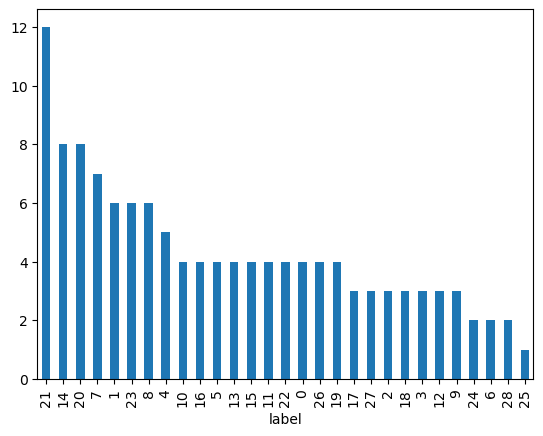

In [ ]:
df["label"].value_counts().plot(kind="bar")

<Axes: xlabel='label'>

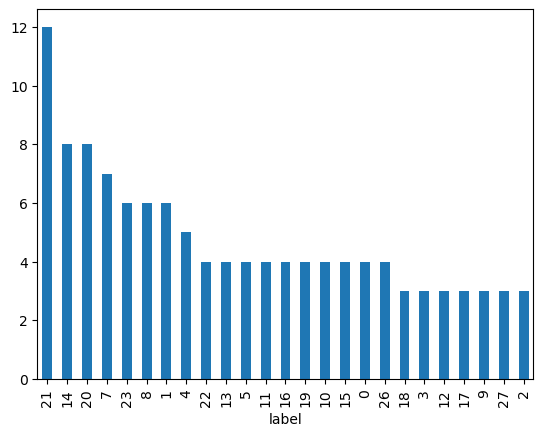

In [ ]:
# let's filter out the individuals that have less than 3 images
min3labels = df["label"].value_counts()[df["label"].value_counts() >= 3].index
min3df = df[df["label"].isin(min3labels)]
min3df.reset_index(drop=True, inplace=True)
min3df["label"].value_counts().plot(kind="bar")

In [ ]:
knn(torch.tensor(min3df.embedding), min3df.label.to_numpy(), k=1)

knn done


/workspaces/gorillatracker/src/gorillatracker/metrics.py:407: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_embeddings = torch.tensor(val_embeddings)
/opt/conda/envs/research/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


{'accuracy': 0.7478991746902466,
 'accuracy_top5': 0.7899159789085388,
 'auroc': 0.7564400434494019,
 'f1': 0.721748948097229}

In [ ]:
knn(torch.tensor(min3df.embedding), min3df.label.to_numpy(), k=5)

knn done


{'accuracy': 0.6386554837226868,
 'accuracy_top5': 0.8739495873451233,
 'auroc': 0.7971510291099548,
 'f1': 0.5982396006584167}

# Realworld
In a real world context, we'll see new individuals arriving over time. 

Options:
- on centroids (of known classes and of new individuals)
- with boolean filter (individuals seen at the same time)


Relevant Metrics:
- What is the average/min/max distance within images of an individual? 
- What is the average distance between centroids of individuals?
- What is the change in average distance between centroids of faces for increasing margins (0.5, 0.1. 1.5, 2, 4, 8)?


In [ ]:
# We'll now operate on the min 3 images model:

grouped = df.groupby(["label", "label_string"])["embedding"].apply(lambda x: np.mean(np.vstack(x), axis=0))
centroid_df = pd.DataFrame({"centroid": grouped.values})
centroid_df[["label", "label_string"]] = pd.DataFrame(grouped.index.tolist(), index=centroid_df.index)
assert len(centroid_df['label'].unique()) == len(centroid_df['label_string'].unique()), "Label does not have a 1:1 mapping with label_string"
centroid_df

,centroid,label,label_string
0,"[0.25615078, -0.23632193, 0.20027858, -0.00398...",0,AY04
1,"[-0.47869778, 1.0439414, -0.2466879, 0.0670568...",1,ES00
2,"[-0.35777605, 0.509797, -0.3298081, 0.80672616...",2,HU40
3,"[-0.24415813, -0.47637203, 0.13456154, 0.13157...",3,JP00
4,"[-0.736521, 0.40235296, 0.8045128, 0.16160214,...",4,JP01
5,"[-0.35894245, 0.694952, -0.25665504, -0.046200...",5,ME60
6,"[-1.06867, -0.20142436, -0.62798244, 0.5471459...",7,NN41
7,"[-0.03223269, 0.8454601, -0.40872586, 1.007949...",8,OE02
8,"[-0.067772515, 0.17625214, 0.24029577, -0.2749...",9,PL00
9,"[-0.083842486, 0.18788311, 0.07386561, 0.73731...",10,PL03


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

for label in centroid_df['label']:
    centroid = centroid_df[centroid_df['label'] == label]['centroid'].values[0]
    embeddings = df[df['label'] == label]['embedding'].tolist()
    distances = cdist(embeddings, [centroid])
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    avg_distance = np.mean(distances)
    centroid_df.loc[centroid_df['label'] == label, 'min_distance'] = min_distance
    centroid_df.loc[centroid_df['label'] == label, 'max_distance'] = max_distance
    centroid_df.loc[centroid_df['label'] == label, 'avg_distance'] = avg_distance

centroid_df


,centroid,label,label_string,min_distance,max_distance,avg_distance
0,"[0.25615078, -0.23632193, 0.20027858, -0.00398...",0,AY04,4.274641,7.153848,5.341000
1,"[-0.47869778, 1.0439414, -0.2466879, 0.0670568...",1,ES00,4.086142,6.351923,5.121992
2,"[-0.35777605, 0.509797, -0.3298081, 0.80672616...",2,HU40,3.374370,4.044274,3.758302
3,"[-0.24415813, -0.47637203, 0.13456154, 0.13157...",3,JP00,5.237472,6.140252,5.790362
4,"[-0.736521, 0.40235296, 0.8045128, 0.16160214,...",4,JP01,2.302225,3.891850,3.252910
5,"[-0.35894245, 0.694952, -0.25665504, -0.046200...",5,ME60,2.700521,3.408201,2.977749
6,"[-1.06867, -0.20142436, -0.62798244, 0.5471459...",7,NN41,2.896077,5.721196,4.039916
7,"[-0.03223269, 0.8454601, -0.40872586, 1.007949...",8,OE02,3.628132,5.853708,4.652968
8,"[-0.067772515, 0.17625214, 0.24029577, -0.2749...",9,PL00,4.484810,5.402168,4.879900
9,"[-0.083842486, 0.18788311, 0.07386561, 0.73731...",10,PL03,3.601938,5.329882,4.537644


In [ ]:
from scipy.spatial.distance import cdist

# Compute the pairwise distances between centroids
distances = cdist(centroid_df['centroid'].tolist(), centroid_df['centroid'].tolist())

# Compute the average distance between classes
avg_distance = np.mean(distances)

avg_distance


6.94547092618428

tsne done


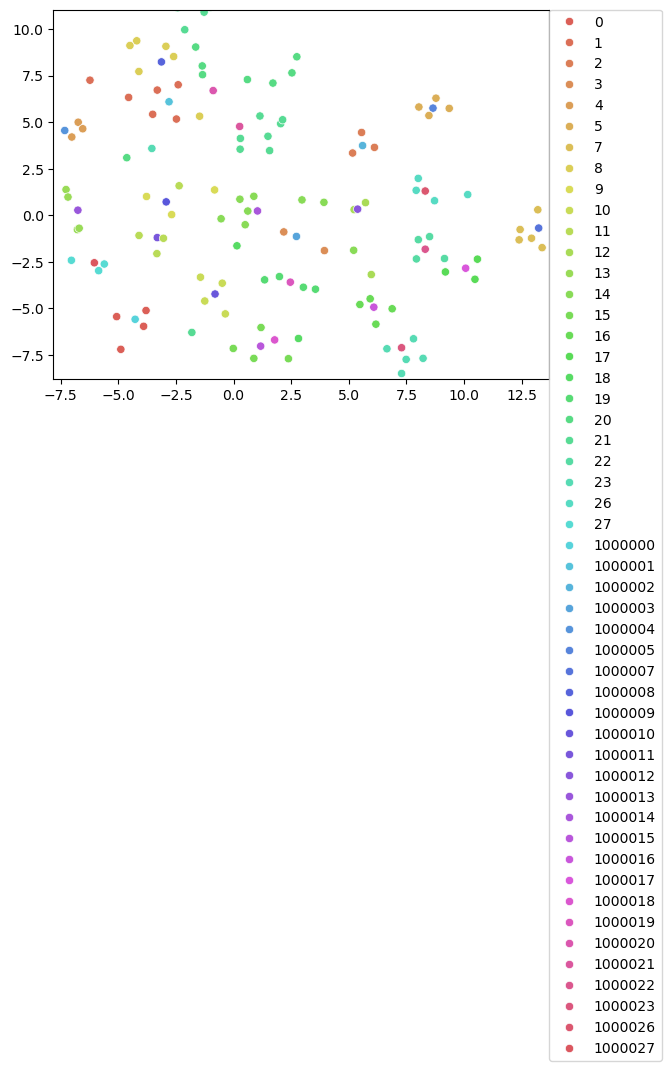

In [ ]:
%autoreload 2

from gorillatracker.metrics import tsne

centroid_marker = 1000000
# p = tsne(torch.tensor(centroid_df.centroid.tolist()), torch.tensor(centroid_df.label.tolist()), perplexity=min(30, len(centroid_df)-1))
p = tsne(torch.tensor(df.embedding.tolist() + centroid_df.centroid.tolist()), torch.tensor(df.label.tolist() + [centroid_marker + c for c in centroid_df.label.tolist()]))

In [ ]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=centroid_df.label.nunique(), random_state=42)
outputs = k_means.fit_predict(embeddings)
k_means.cluster_centers_, outputs

NameError: name 'centroid_df' is not defined

In [ ]:
# Add all train embeddings
# Then add embeddings from validation and check how close they are to the centroids
# 
# Check how many images we have per individual.